In [1]:
import pandas as pd
import zipfile
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)

categories = {c: i for i, c in enumerate(set(df.Product_Category))}

df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Category'] = df.Product_Category.apply(lambda x: categories[x])
df['Date'] = pd.to_datetime(df['Date']) 
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['Weeks']  = df['Date'].dt.to_period('W').dt.to_timestamp()

In [3]:
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand']].groupby('Weeks').sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand']].groupby('Months').sum().reset_index().sort_values('Months')

<Axes: xlabel='Months'>

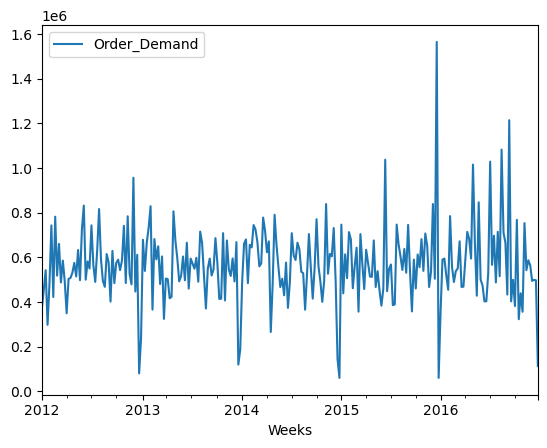

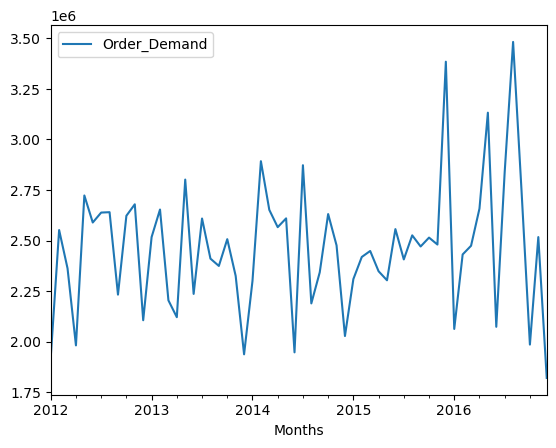

In [4]:
weekly.plot(x ='Weeks', y='Order_Demand')
monthly.plot(x ='Months', y='Order_Demand')

In [5]:
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand','Category' ]].groupby(['Weeks', 'Category']).sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand', 'Category']].groupby(['Months', 'Category']).sum().reset_index().sort_values('Months')

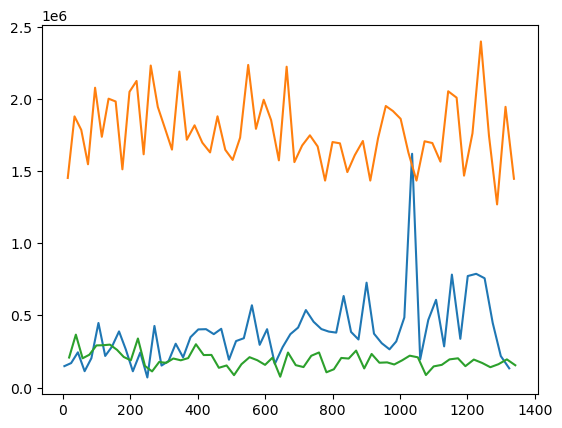

In [6]:
for _, i in categories.items():
    if monthly[monthly.Category == i].Order_Demand.sum() > 10000000:
        plt.plot(monthly[monthly.Category == i].Order_Demand)
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 

from sklearn.preprocessing import MinMaxScaler


<Axes: xlabel='Weeks'>

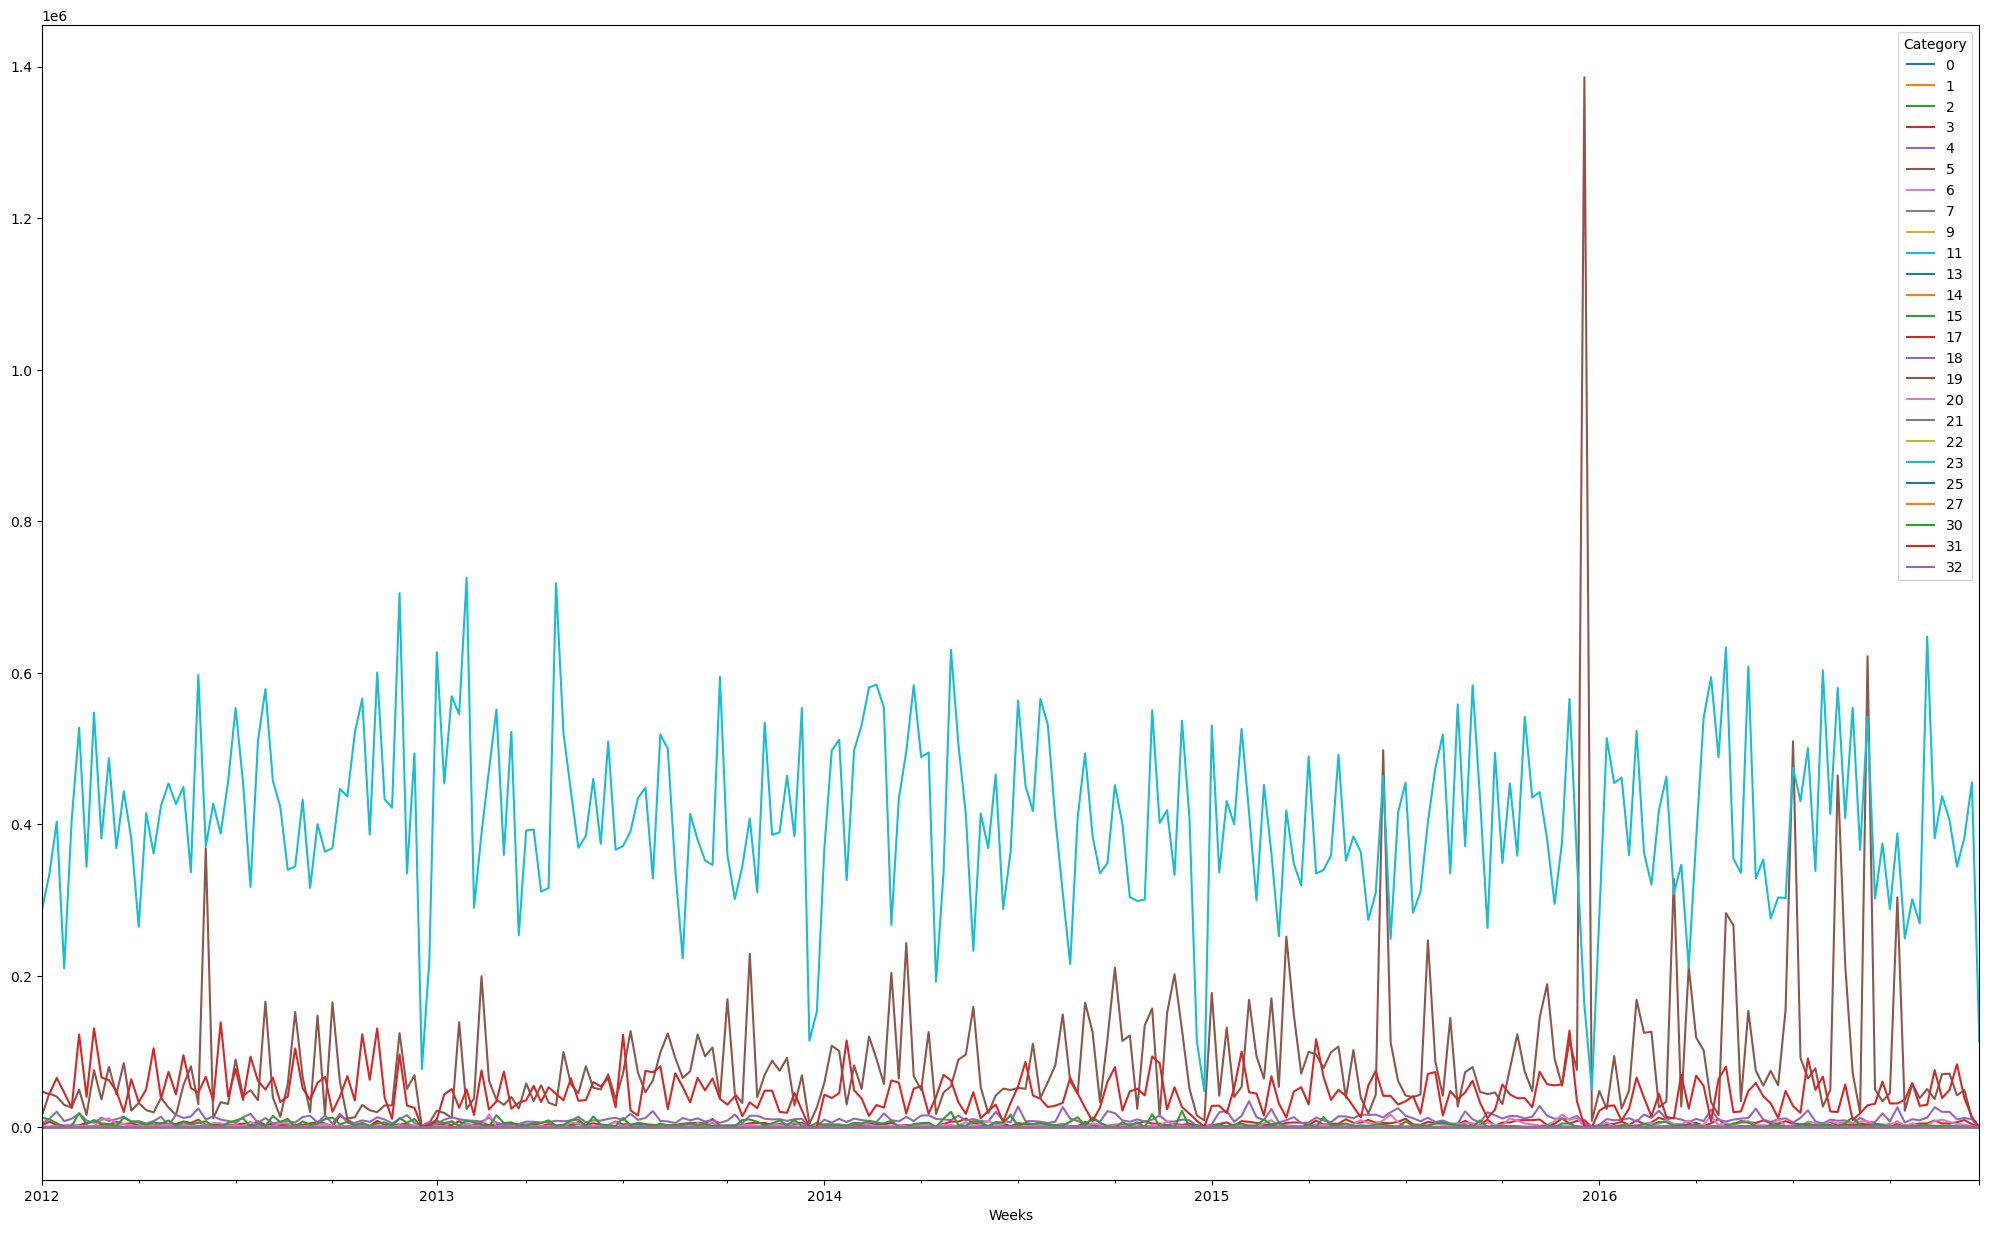

In [8]:
data_pivot = weekly.pivot(index='Weeks', columns='Category', values='Order_Demand').fillna(0)

data_pivot.plot(figsize=(25, 15))

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_pivot)

In [10]:
scaled_data.shape

(261, 25)

In [11]:
N = data_pivot.shape[1]
History = 4 # Weeks

In [47]:
def data():
    X = scaled_data
    inputs = []
    predictions = []
    for i in range(History, len(X)-History):
        x_input = X[i-History:i]
        z = X[i:i+History]
        inputs.append(x_input)
        predictions.append(z)
    return np.array(inputs), np.array(predictions)        
i,l = data()

In [58]:
class AutoRegressive(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = LSTMCell(units)
    self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
    self.dense = Dense(25)
    
  def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    
    for n in range(1, self.out_steps):
      x = prediction
      x, state = self.lstm_cell(x, states=state, training=training)
      prediction = self.dense(x)
      predictions.append(prediction)
    
    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


In [59]:
model = AutoRegressive(32, History)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])

Model: "auto_regressive_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_cell_3 (LSTMCell)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_3 (RNN)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
i.shape, l.shape

((253, 4, 25), (253, 4, 25))

In [69]:
hist = model.fit(i, l, batch_size=8, epochs=250)

Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841

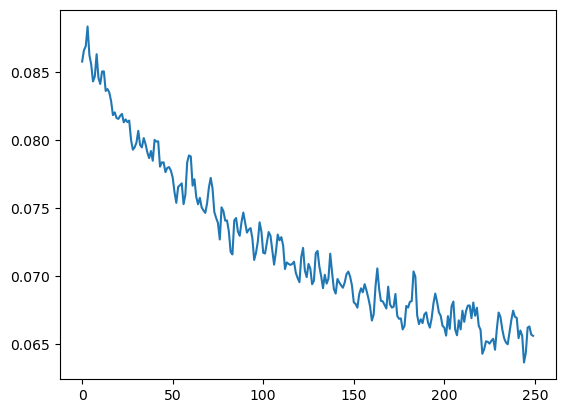

In [72]:
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')

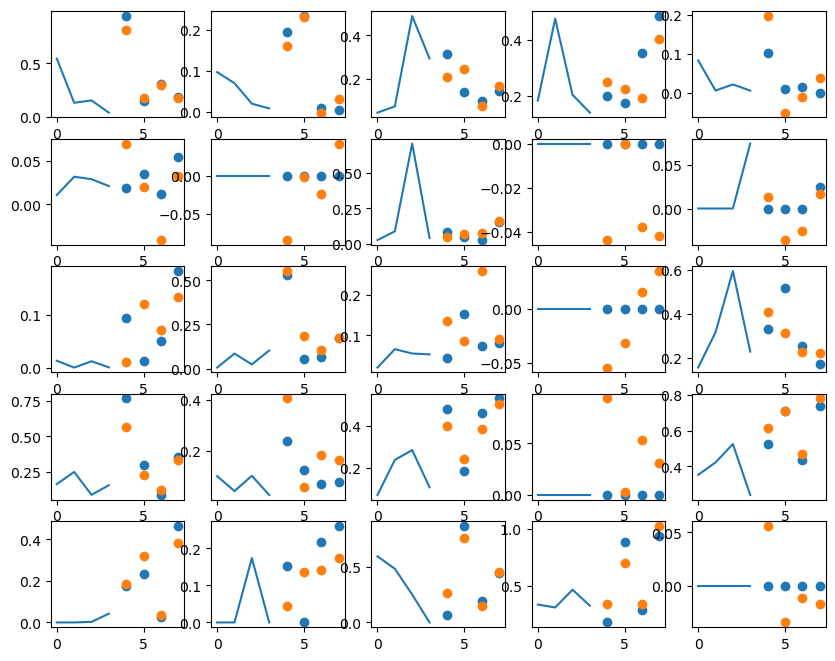

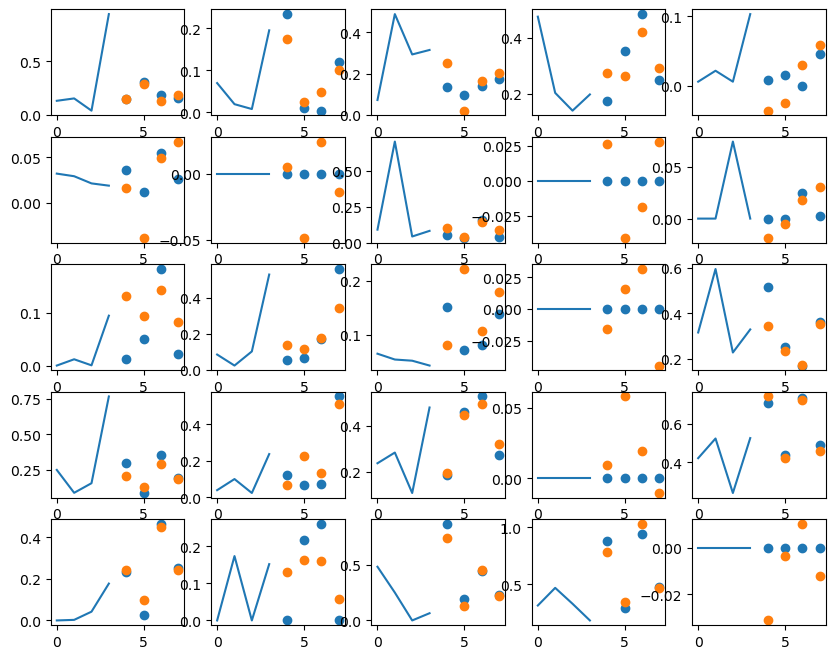

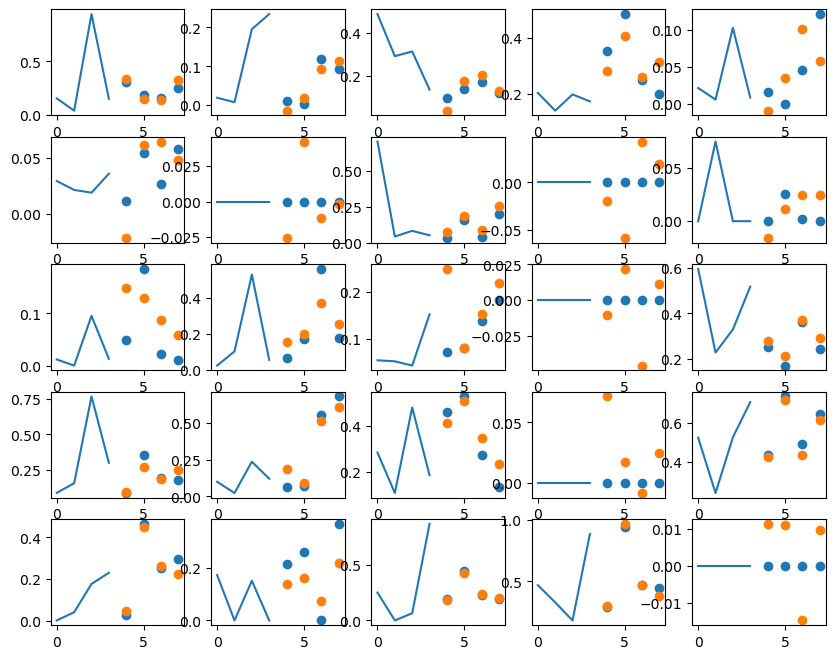

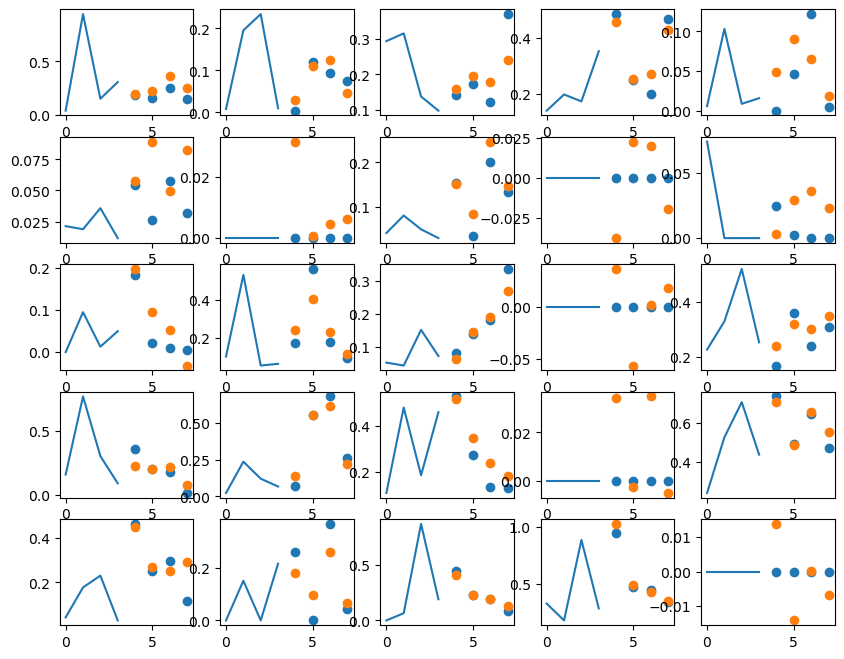

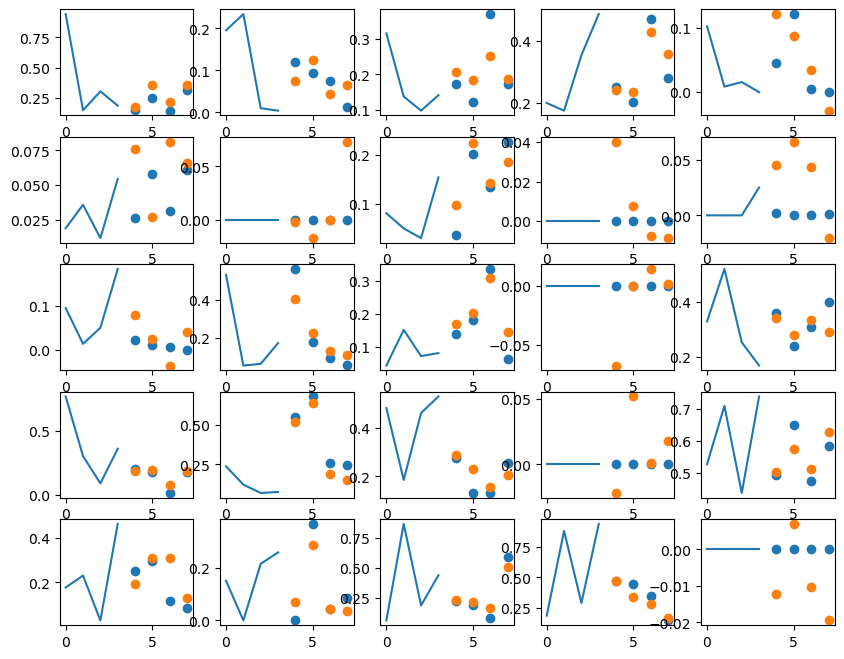

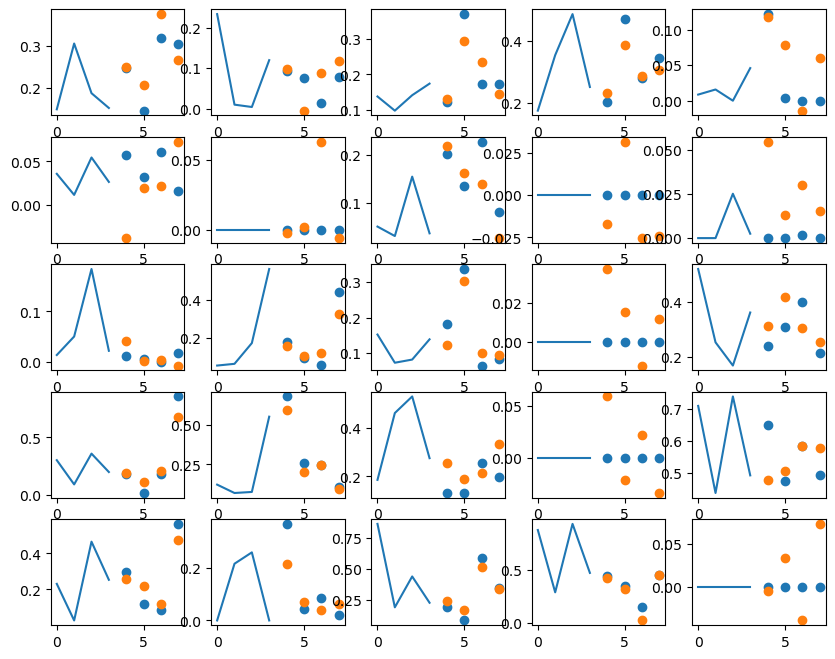

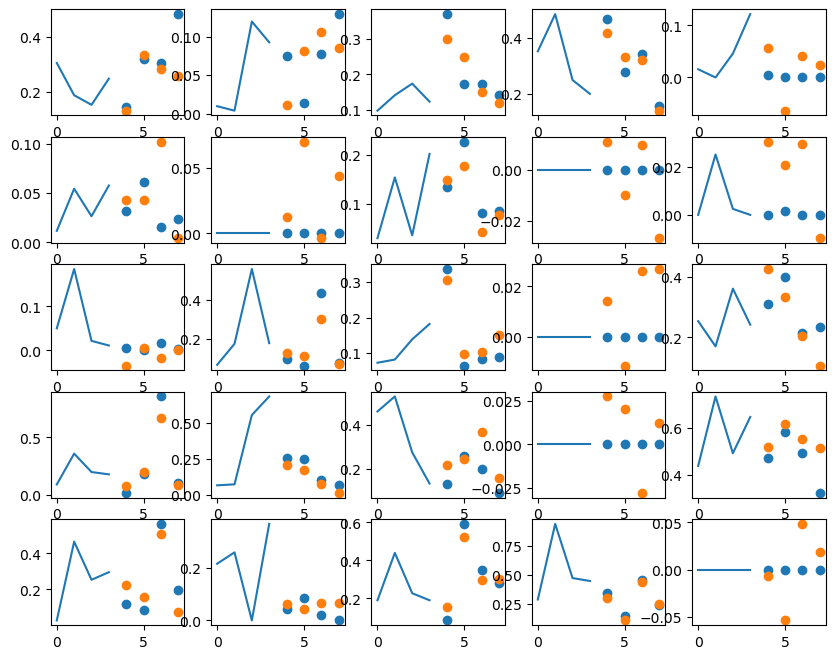

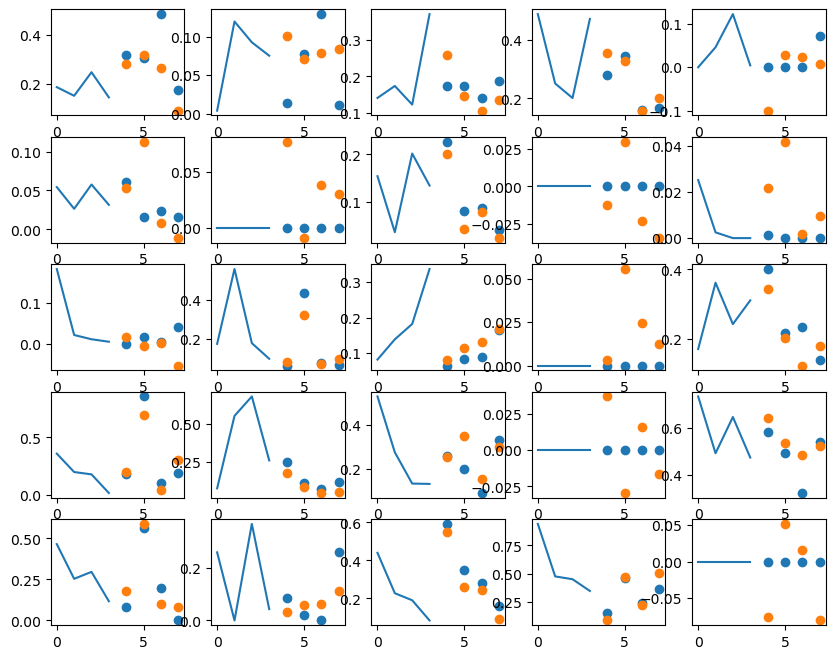

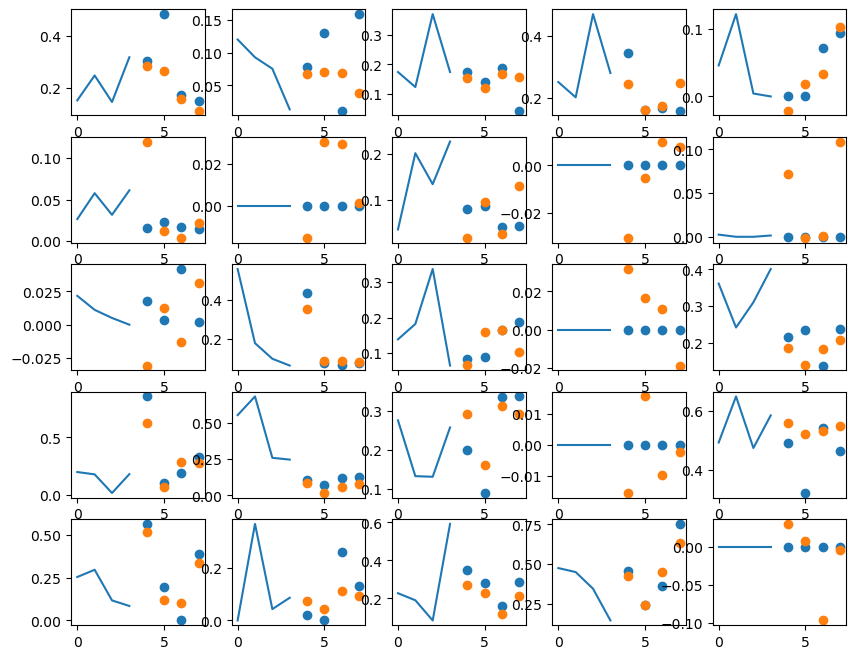

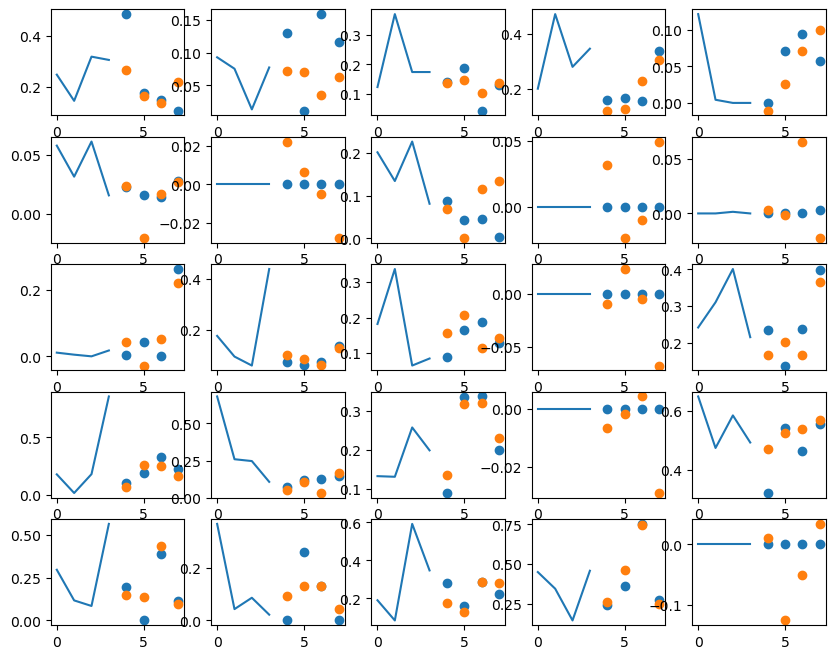

In [73]:
for k in range(0, 10):
    plt.figure(figsize=(10, 8))
    for j in range(0, 25):
        plt.subplot(5,5, j + 1)
        gt = list(i[k,:,j])
        x  = np.arange(History,2 * History)
        y  = list(l[k,:,j])
        _y = model(i[k].reshape((1,4,25)))[0,:,j]    
        plt.plot(gt)
        plt.scatter(x, y)
        plt.scatter(x, _y)
    plt.show()